# Advanced Dropout Regularization for Regression Tasks

In [10]:
mport torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader

torch.manual_seed(42)  # For reproducibility

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

SyntaxError: invalid syntax (3540524312.py, line 1)

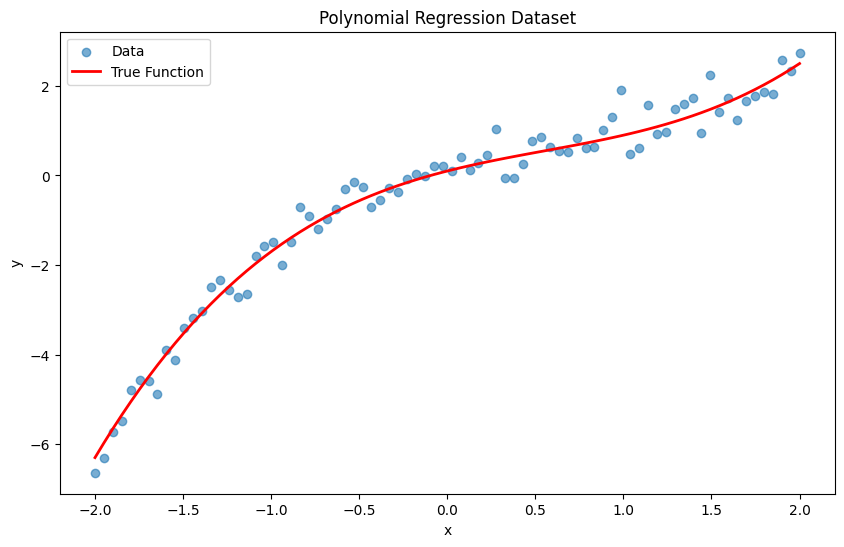

In [11]:
# Simple polynomial dataset for regression tasks
class PolyDataset(Dataset):
    def __init__(self, n_samples=100, noise=0.3, train=True):
        # Generate input values from -2 to 2
        self.x = torch.linspace(-2, 2, n_samples).view(-1, 1)
        
        # True function: cubic polynomial
        self.f = 0.3 * self.x**3 - 0.5 * self.x**2 + self.x + 0.1
        
        # Add noise to targets (different noise for train/val)
        seed = 0 if train else 1
        torch.manual_seed(seed)
        self.y = self.f + noise * torch.randn(self.f.size())
        torch.manual_seed(42)
        
        self.len = n_samples
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]
    
    def __len__(self):
        return self.len
    
    def plot(self):
        plt.figure(figsize=(10, 6))
        plt.scatter(self.x.numpy(), self.y.numpy(), alpha=0.6, label='Data')
        plt.plot(self.x.numpy(), self.f.numpy(), 'r-', linewidth=2, label='True Function')
        plt.legend()
        plt.title('Polynomial Regression Dataset')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.show()

# Create datasets
train_data = PolyDataset(n_samples=80, train=True)
val_data = PolyDataset(n_samples=40, train=False)
train_data.plot()

In [12]:
class DropoutNet(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, dropout_probs):
        super(DropoutNet, self).__init__()
        
        # Create layers
        layers = []
        
        # First layer: input → first hidden
        layers.append(nn.Linear(input_size, hidden_sizes[0]))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(dropout_probs[0]))
        
        # Hidden layers
        for i in range(1, len(hidden_sizes)):
            layers.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_probs[i]))
        
        # Output layer
        layers.append(nn.Linear(hidden_sizes[-1], output_size))
        
        # Combine layers into sequential model
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [13]:
def train_model(model, train_data, val_data, epochs=200, batch_size=16):
    # Create data loader
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    
    # Loss and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    # Initialize history tracking
    train_losses = []
    
    # Training loop
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0
        
        # Batch training
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            
            # Forward pass
            outputs = model(x)
            loss = criterion(outputs, y)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        # Record average epoch loss
        train_losses.append(epoch_loss / len(train_loader))
        
        # Validation every 50 epochs
        if (epoch + 1) % 50 == 0:
            model.eval()
            with torch.no_grad():
                val_x, val_y = val_data.x.to(device), val_data.y.to(device)
                val_pred = model(val_x)
                val_loss = criterion(val_pred, val_y).item()
                print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_loss:.4f}")
    
    # Final validation
    model.eval()
    with torch.no_grad():
        val_x, val_y = val_data.x.to(device), val_data.y.to(device)
        val_pred = model(val_x)
        val_loss = criterion(val_pred, val_y).item()
        print(f"Final Validation Loss: {val_loss:.4f}")
    
    return train_losses, val_loss

In [14]:
# Define dropout configurations
dropout_configs = [
    {"name": "No Dropout", "probs": [0.0, 0.0, 0.0]},
    {"name": "Light Dropout", "probs": [0.2, 0.2, 0.2]},
    {"name": "Medium Dropout", "probs": [0.4, 0.4, 0.4]},
    {"name": "Heavy Dropout", "probs": [0.6, 0.6, 0.6]}
]

# Train models with different dropout rates
models = {}
train_histories = {}
val_losses = {}

print("=== Training Models with Different Dropout Rates ===")

for config in dropout_configs:
    print(f"\nTraining {config['name']}...")
    
    # Create model
    model = DropoutNet(
        input_size=1,
        hidden_sizes=[100, 80, 60],
        output_size=1,
        dropout_probs=config['probs']
    ).to(device)
    
    # Train model
    train_loss_hist, val_loss = train_model(model, train_data, val_data)
    
    # Store results
    models[config['name']] = model
    train_histories[config['name']] = train_loss_hist
    val_losses[config['name']] = val_loss

=== Training Models with Different Dropout Rates ===

Training No Dropout...
Epoch [50/200], Train Loss: 0.1152, Val Loss: 0.0860
Epoch [100/200], Train Loss: 0.0994, Val Loss: 0.0792
Epoch [150/200], Train Loss: 0.1091, Val Loss: 0.0874
Epoch [200/200], Train Loss: 0.1019, Val Loss: 0.0938
Final Validation Loss: 0.0938

Training Light Dropout...
Epoch [50/200], Train Loss: 0.2930, Val Loss: 0.1103
Epoch [100/200], Train Loss: 0.2082, Val Loss: 0.0791
Epoch [150/200], Train Loss: 0.2429, Val Loss: 0.0741
Epoch [200/200], Train Loss: 0.2413, Val Loss: 0.0908
Final Validation Loss: 0.0908

Training Medium Dropout...
Epoch [50/200], Train Loss: 0.6364, Val Loss: 0.1526
Epoch [100/200], Train Loss: 0.7399, Val Loss: 0.3918
Epoch [150/200], Train Loss: 0.5237, Val Loss: 0.0930
Epoch [200/200], Train Loss: 0.5123, Val Loss: 0.0822
Final Validation Loss: 0.0822

Training Heavy Dropout...
Epoch [50/200], Train Loss: 1.0126, Val Loss: 0.5273
Epoch [100/200], Train Loss: 0.9361, Val Loss: 0.3559

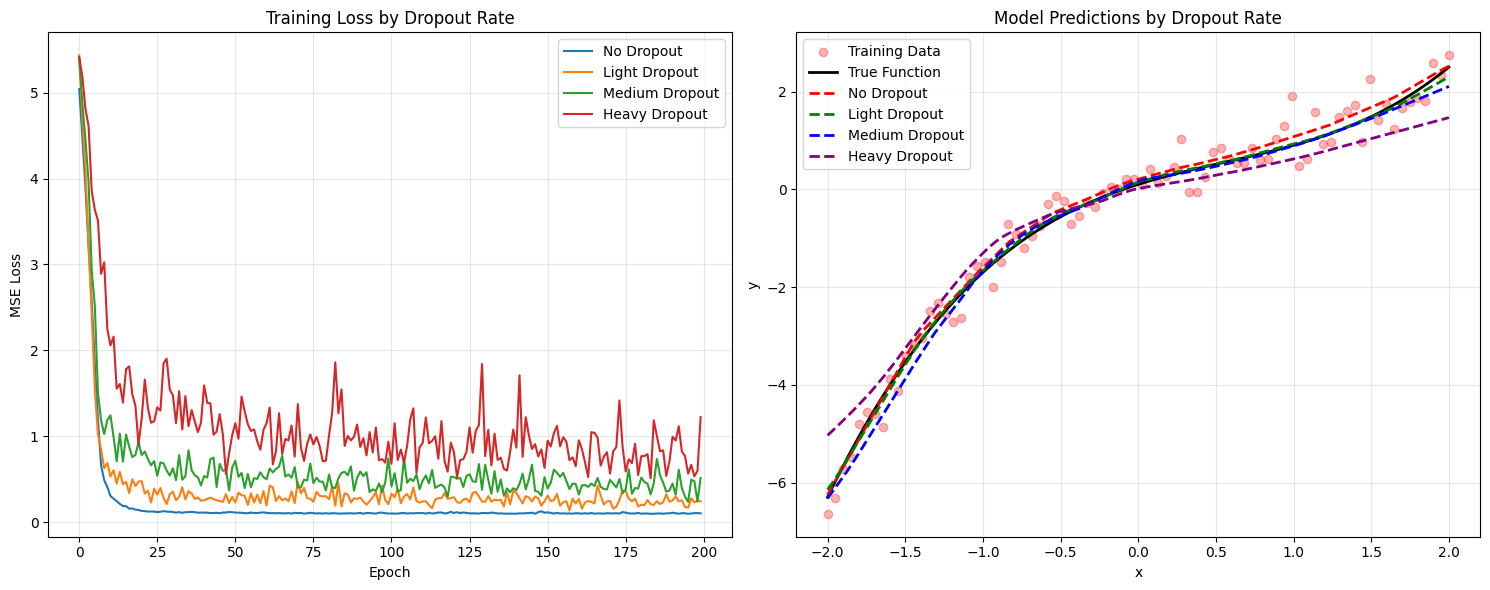


=== Validation Results ===
Model           Validation MSE 
------------------------------
No Dropout      0.0938         
Light Dropout   0.0908         
Medium Dropout  0.0822         
Heavy Dropout   0.3922         

Best Model: Medium Dropout (Validation MSE: 0.0822)

=== Dropout Effectiveness for Regression ===
• In regression, dropout helps prevent overfitting to noise
• Too much dropout can cause underfitting (high bias)
• The optimal dropout rate balances fitting the pattern vs. noise
• Different from classification, where dropout often needs to be higher
• Always validate your dropout rate - what works varies by problem!


In [18]:
def plot_results():
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot 1: Training Loss Comparison
    for config in dropout_configs:
        name = config['name']
        ax1.plot(train_histories[name], label=name)
    
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('MSE Loss')
    ax1.set_title('Training Loss by Dropout Rate')
    ax1.legend()
    ax1.grid(alpha=0.3)
    
    # Plot 2: Model predictions
    x_plot = torch.linspace(-2, 2, 100).view(-1, 1).to(device)
    
    # Plot data points and true function
    ax2.scatter(
        train_data.x.numpy(), 
        train_data.y.numpy(), 
        alpha=0.3, 
        color='red',
        label='Training Data'
    )
    ax2.plot(
        train_data.x.numpy(), 
        train_data.f.numpy(), 
        'k-', 
        linewidth=2, 
        label='True Function'
    )
    
    # Plot model predictions
    colors = ['red', 'green', 'blue', 'purple']
    for i, config in enumerate(dropout_configs):
        name = config['name']
        model = models[name]
        
        # Get predictions
        model.eval()
        with torch.no_grad():
            y_pred = model(x_plot).cpu().numpy()
        
        # Plot predictions
        ax2.plot(
            x_plot.cpu().numpy(), 
            y_pred, 
            color=colors[i],
            linewidth=2, 
            linestyle='--',
            label=f"{name}"
        )
    
    ax2.set_xlabel('x')
    ax2.set_ylabel('y')
    ax2.set_title('Model Predictions by Dropout Rate')
    ax2.legend()
    ax2.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Plot results
plot_results()

# Display validation metrics
print("\n=== Validation Results ===")
print(f"{'Model':<15} {'Validation MSE':<15}")
print("-" * 30)

for config in dropout_configs:
    name = config['name']
    print(f"{name:<15} {val_losses[name]:<15.4f}")

# Identify best model
best_model_name = min(val_losses, key=val_losses.get)
print(f"\nBest Model: {best_model_name} (Validation MSE: {val_losses[best_model_name]:.4f})")

# Dropout effectiveness summary
print("\n=== Dropout Effectiveness for Regression ===")
print("• In regression, dropout helps prevent overfitting to noise")
print("• Too much dropout can cause underfitting (high bias)")
print("• The optimal dropout rate balances fitting the pattern vs. noise")
print("• Different from classification, where dropout often needs to be higher")
print("• Always validate your dropout rate - what works varies by problem!")